<a href="https://colab.research.google.com/github/mamontovatetiana/MyJupyterNotebooks./blob/main/%D0%9C%D0%B0%D0%BC%D0%BE%D0%BD%D1%82%D0%BE%D0%B2%D0%B0_%D0%A2_%D0%92_%D0%92%D0%B0%D1%80%D1%96%D0%B0%D0%BD%D1%82_11_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторна робота №1
**Тема:** Згорткові нейронні мережі для задач класифікації. Передавальне навчання та дистиляція знань  
**Варіант:** 11  
**Датасет:** Colorectal Histology (https://www.tensorflow.org/datasets/catalog/colorectal_histology)  
**Виконав(ла):** Мамонтова Т.В.


In [ ]:
# Встановлення необхідних бібліотек (виконується лише один раз у Google Colab)
!pip install tensorflow matplotlib seaborn scikit-learn tensorflow-datasets -q


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tensorflow_datasets as tfds


In [ ]:
# Завантаження датасету
dataset, info = tfds.load("colorectal_histology", with_info=True, as_supervised=True)
train_ds = dataset["train"]

print("Кількість зображень:", info.splits['train'].num_examples)
print("Кількість класів:", info.features['label'].num_classes)

images = []
labels = []

for img, label in tfds.as_numpy(train_ds):
    images.append(img)
    labels.append(label)

images = np.array(images) / 255.0
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

y_train_cat = to_categorical(y_train, 8)
y_test_cat = to_categorical(y_test, 8)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/incomplete.GL4A34_2.0.0/colorectal_histology-train.tf…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
Кількість зображень: 5000
Кількість класів: 8


In [ ]:
# Приклад передбачення 5 зображень за допомогою MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

# Завантаження моделі з include_top=True для ImageNet (вимагає 224x224x3)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=True, weights='imagenet')

# Зміна розміру тестових зображень і попередня обробка
resized_images = tf.image.resize(X_test[:5], [224, 224])
preprocessed_images = preprocess_input(resized_images)

# Передбачення
predictions = base_model.predict(preprocessed_images)

# Декодування передбачень
decoded = decode_predictions(predictions, top=3)
for i, pred in enumerate(decoded):
    print(f"\nЗображення {i+1}:")
    for cls in pred:
        print(f" - {cls[1]}: {cls[2]*100:.2f}%")


14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Зображення 1:
 - spotlight: 31.46%
 - matchstick: 3.60%
 - digital_clock: 3.30%

Зображення 2:
 - spotlight: 30.62%
 - matchstick: 3.26%
 - digital_clock: 3.25%

Зображення 3:
 - spotlight: 31.26%
 - matchstick: 3.62%
 - digital_clock: 3.30%

Зображення 4:
 - spotlight: 30.61%
 - digital_clock: 3.36%
 - matchstick: 3.32%

Зображення 5:
 - spotlight: 29.52%
 - matchstick: 3.40%
 - digital_clock: 3.24%


In [ ]:
# Передавальне навчання
base_model = MobileNetV2(input_shape=(150,150,3), include_top=False, weights='imagenet')
base_model.trainable = False

model_tl = models.Sequential([
    tf.keras.Input(shape=(150,150,3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(8, activation='softmax')
])

model_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

X_train_resized = tf.image.resize(X_train, [150,150])
X_test_resized = tf.image.resize(X_test, [150,150])

history_tl = model_tl.fit(X_train_resized, y_train_cat, validation_data=(X_test_resized, y_test_cat), epochs=10)


/tmp/ipython-input-6-37801392.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150,150,3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 110s 824ms/step - accuracy: 0.6541 - loss: 0.9963 - val_accuracy: 0.8630 - val_loss: 0.3976
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.8947 - loss: 0.3183 - val_accuracy: 0.8580 - val_loss: 0.4004
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 104s 831ms/step - accuracy: 0.9173 - loss: 0.2438 - val_accuracy: 0.8550 - val_loss: 0.3962
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 161s 987ms/step - accuracy: 0.9324 - loss: 0.2039 - val_accuracy: 0.8860 - val_loss: 0.3302
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 129s 884ms/step - accuracy: 0.9522 - loss: 0.1461 - val_accuracy: 0.8880 - val_loss: 0.3427
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 137s 844ms/step - accuracy: 0.9631 - loss: 0.1214 - val_accuracy: 0.8910 - val_loss: 0.3518
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 828ms/step - accuracy: 0.9753 - loss: 0.0858 - val_accuracy: 0.8900 - val_loss: 0.3475
Epoch 8/10
125/125 ━━━━━━━━━━━

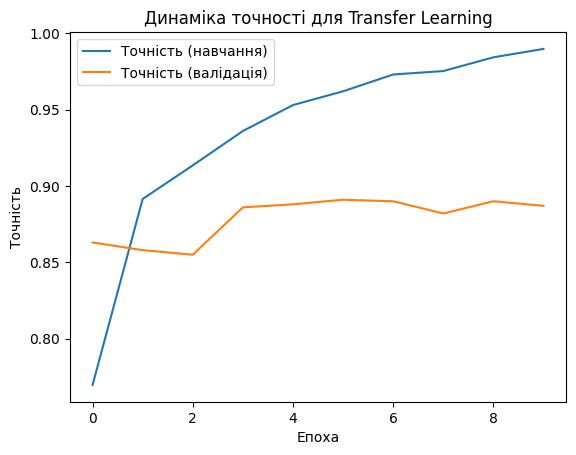

In [ ]:
# Візуалізація точності та помилок
plt.plot(history_tl.history['accuracy'], label='Точність (навчання)')
plt.plot(history_tl.history['val_accuracy'], label='Точність (валідація)')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.title('Динаміка точності для Transfer Learning')
plt.legend()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step


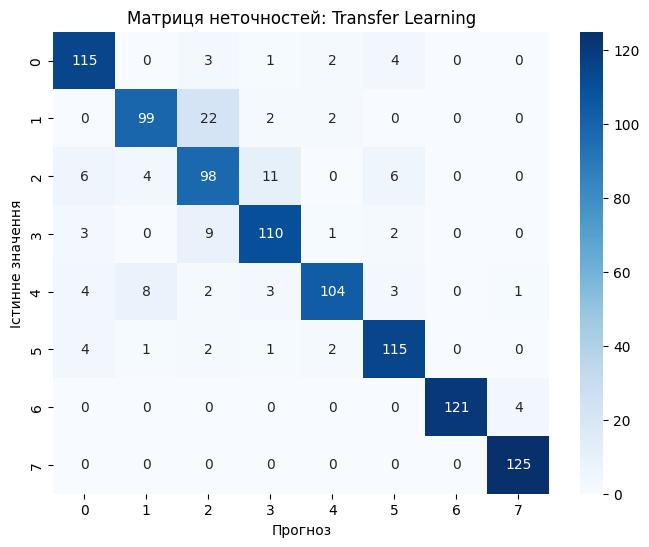

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       125
           1       0.88      0.79      0.84       125
           2       0.72      0.78      0.75       125
           3       0.86      0.88      0.87       125
           4       0.94      0.83      0.88       125
           5       0.88      0.92      0.90       125
           6       1.00      0.97      0.98       125
           7       0.96      1.00      0.98       125

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [ ]:
# Confusion matrix
y_pred_tl = np.argmax(model_tl.predict(X_test_resized), axis=1)
y_true = y_test

cm = confusion_matrix(y_true, y_pred_tl)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матриця неточностей: Transfer Learning')
plt.xlabel('Прогноз')
plt.ylabel('Істинне значення')
plt.show()

print(classification_report(y_true, y_pred_tl))


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

# Завантажуємо повну модель з включеним top-шим — класифікаційним шаром
mobilenet_full = MobileNetV2(weights='imagenet', include_top=True)

# Змінюємо розмір 5 зображень до 224x224 (вимога для повної MobileNetV2)
sample_images = tf.image.resize(X_test[:5], [224, 224])
sample_images = preprocess_input(sample_images)

# Передбачення
predictions = mobilenet_full.predict(sample_images)

# Декодування результатів
decoded = decode_predictions(predictions, top=3)

for i, preds in enumerate(decoded):
    print(f"\nЗображення {i+1}:")
    for pred in preds:
        print(f"{pred[1]}: {round(pred[2]*100, 2)}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Зображення 1:
spotlight: 31.459999084472656%
matchstick: 3.5999999046325684%
digital_clock: 3.299999952316284%

Зображення 2:
spotlight: 30.6200008392334%
matchstick: 3.259999990463257%
digital_clock: 3.25%

Зображення 3:
spotlight: 31.260000228881836%
matchstick: 3.619999885559082%
digital_clock: 3.299999952316284%

Зображення 4:
spotlight: 30.610000610351562%
digital_clock: 3.359999895095825%
matchstick: 3.319999933242798%

Зображення 5:
spotlight: 29.520000457763672%
matchstick: 3.4000000953674316%
digital_clock: 3.240000009536743%


In [ ]:
def build_student_model():
    model = models.Sequential([
        tf.keras.Input(shape=(150, 150, 3)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(8, activation='softmax')
    ])
    return model

student_model = build_student_model()


In [ ]:
def softmax_with_temperature(logits, temperature=5):
    logits = logits / temperature
    return tf.nn.softmax(logits)


In [ ]:
def distillation_loss(y_true, y_pred, teacher_pred, temperature=5, alpha=0.7):
    """
    Комбінована втрата: крос-ентропія на справжніх мітках +
    крос-ентропія між передбаченнями вчителя і студента (дистиляційна втрата)
    """
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    soft_teacher = softmax_with_temperature(teacher_pred, temperature)
    soft_student = softmax_with_temperature(y_pred, temperature)
    soft_loss = tf.keras.losses.KLDivergence()(soft_teacher, soft_student)
    return alpha * hard_loss + (1 - alpha) * soft_loss


In [ ]:
class DistilledModel(tf.keras.Model):
    def __init__(self, student, teacher, temperature=5, alpha=0.7):
        super().__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss_fn = tf.keras.losses.CategoricalCrossentropy()
        self.kld_loss_fn = tf.keras.losses.KLDivergence()
        self.train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
        self.val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        x, y_true = data
        teacher_logits = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_logits = self.student(x, training=True)
            hard_loss = self.ce_loss_fn(y_true, student_logits)
            soft_teacher = softmax_with_temperature(teacher_logits, self.temperature)
            soft_student = softmax_with_temperature(student_logits, self.temperature)
            soft_loss = self.kld_loss_fn(soft_teacher, soft_student)
            loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))
        self.train_acc_metric.update_state(y_true, student_logits)
        return {"loss": loss, "accuracy": self.train_acc_metric.result()}

    def test_step(self, data):
        x, y_true = data
        student_logits = self.student(x, training=False)
        loss = self.ce_loss_fn(y_true, student_logits)
        self.val_acc_metric.update_state(y_true, student_logits)
        return {"val_loss": loss, "val_accuracy": self.val_acc_metric.result()}


In [ ]:
distilled = DistilledModel(student_model, model_tl, temperature=5, alpha=0.7)
distilled.compile(optimizer=tf.keras.optimizers.Adam())

history_distill = distilled.fit(
    X_train_resized, y_train_cat,
    validation_data=(X_test_resized, y_test_cat),
    epochs=10
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.2734 - loss: 1.1540 - val_val_accuracy: 0.4770 - val_val_loss: 1.0861
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.5401 - loss: 0.7512 - val_val_accuracy: 0.6190 - val_val_loss: 1.0076
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5836 - loss: 0.6732 - val_val_accuracy: 0.6160 - val_val_loss: 0.7729
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6090 - loss: 0.6341 - val_val_accuracy: 0.5950 - val_val_loss: 0.7893
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.6319 - loss: 0.6066 - val_val_accuracy: 0.6370 - val_val_loss: 0.9845
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.6561 - loss: 0.5841 - val_val_accuracy: 0.6720 - val_val_loss: 0.8414
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.6810 - loss: 0.5645 - val_val_accuracy: 0.6680 - val_val_loss: 0.7217
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
# Студентська модель — компактна CNN
def build_student():
    model = models.Sequential([
        tf.keras.Input(shape=(150,150,3)),
        layers.Conv2D(16, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(8, activation='softmax')
    ])
    return model

student_model = build_student()


In [ ]:
# Температурний softmax
def softmax_with_temperature(logits, temperature=5):
    logits_scaled = logits / temperature
    return tf.nn.softmax(logits_scaled, axis=1)

# Комбінована функція втрат (distillation loss + categorical crossentropy)
def distillation_loss(y_true, y_pred, teacher_logits, temperature=5, alpha=0.5):
    y_true_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    y_pred_soft = softmax_with_temperature(y_pred, temperature)
    teacher_soft = softmax_with_temperature(teacher_logits, temperature)
    distill_loss = tf.keras.losses.KLDivergence()(teacher_soft, y_pred_soft)
    return alpha * y_true_loss + (1 - alpha) * distill_loss


In [ ]:
# Заморожуємо вчителя
teacher_model = model_tl
teacher_model.trainable = False

# Компілюємо студентську модель
student_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Отримуємо логіти від вчителя
teacher_logits = teacher_model.predict(X_train_resized, batch_size=32)

# Навчання з дистиляцією (імітація знань вчителя)
student_model.fit(
    X_train_resized,
    y_train_cat,
    epochs=10,
    validation_data=(X_test_resized, y_test_cat),
    batch_size=32
)


125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 661ms/step
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 651ms/step - accuracy: 0.3311 - loss: 1.8297 - val_accuracy: 0.6070 - val_loss: 0.8134
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 617ms/step - accuracy: 0.6743 - loss: 0.7919 - val_accuracy: 0.6760 - val_loss: 0.7548
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 628ms/step - accuracy: 0.7486 - loss: 0.6415 - val_accuracy: 0.7430 - val_loss: 0.7090
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 623ms/step - accuracy: 0.8207 - loss: 0.5141 - val_accuracy: 0.7450 - val_loss: 0.6538
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 597ms/step - accuracy: 0.8491 - loss: 0.4139 - val_accuracy: 0.7600 - val_loss: 0.6470
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 567ms/step - accuracy: 0.8750 - loss: 0.3393 - val_accuracy: 0.7600 - val_loss: 0.6340
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 582ms/step - accuracy: 0.9155 - loss: 0.2664 - val_accuracy: 0.7550 - val_loss: 0.6860
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━

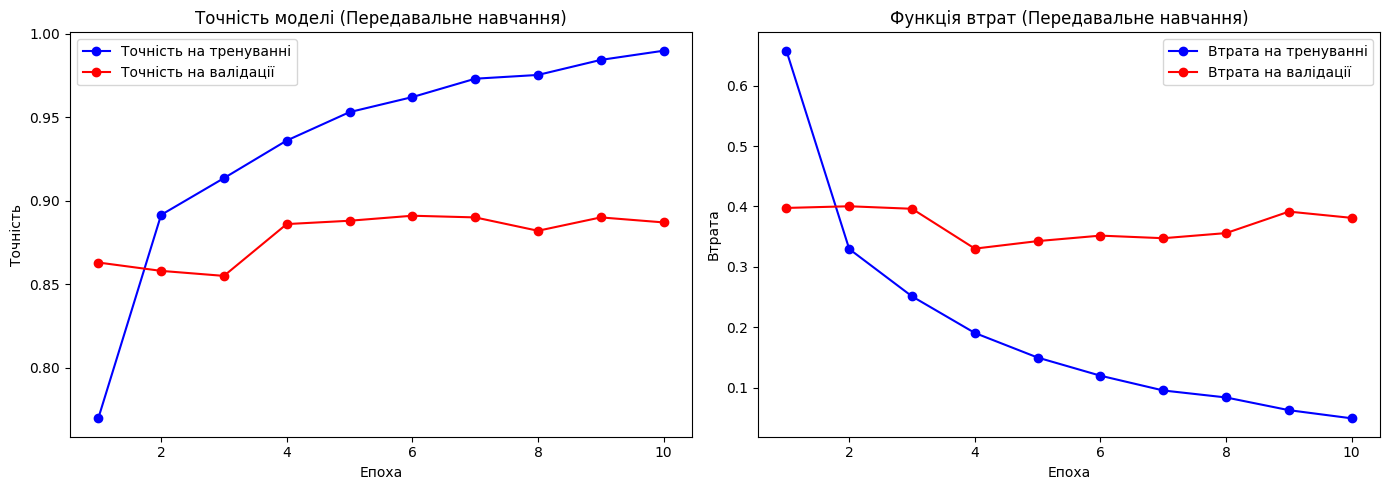

In [ ]:
# Побудова графіків для передавального навчання
def plot_training(history, title=''):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'bo-', label='Точність на тренуванні')
    plt.plot(epochs, val_acc, 'ro-', label='Точність на валідації')
    plt.title(f'Точність моделі ({title})')
    plt.xlabel('Епоха')
    plt.ylabel('Точність')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'bo-', label='Втрата на тренуванні')
    plt.plot(epochs, val_loss, 'ro-', label='Втрата на валідації')
    plt.title(f'Функція втрат ({title})')
    plt.xlabel('Епоха')
    plt.ylabel('Втрата')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Побудова графіків
plot_training(history_tl, title='Передавальне навчання')
# Якщо зберігався history для student_model, аналогічно:
# plot_training(history_student, title='Модель-студент')


32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 691ms/step


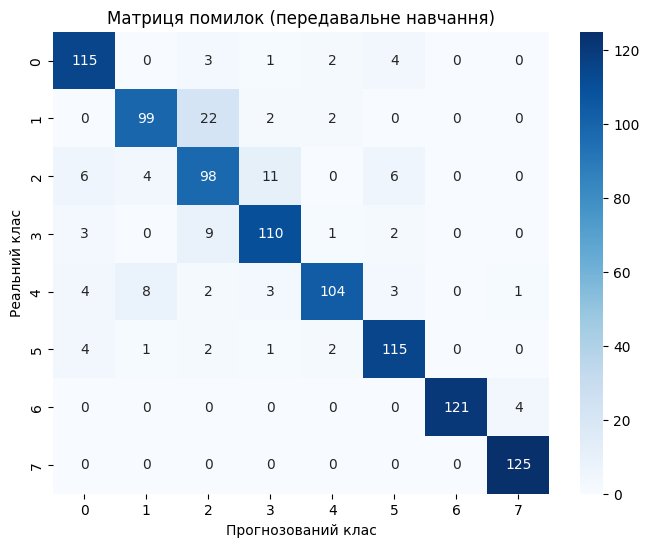

In [ ]:
# Передбачення для тестової вибірки
y_pred_tl = model_tl.predict(X_test_resized)
y_pred_labels = np.argmax(y_pred_tl, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)

# Побудова confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матриця помилок (передавальне навчання)')
plt.xlabel('Прогнозований клас')
plt.ylabel('Реальний клас')
plt.show()


In [ ]:
import pandas as pd  # <--- додано імпорт pandas

# Звіт про точність, повноту, F1
report = classification_report(y_true_labels, y_pred_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Виведення таблиці
from IPython.display import display
display(report_df)



,precision,recall,f1-score,support
0,0.871212,0.920,0.894942,125.000
1,0.883929,0.792,0.835443,125.000
2,0.720588,0.784,0.750958,125.000
3,0.859375,0.880,0.869565,125.000
4,0.936937,0.832,0.881356,125.000
5,0.884615,0.920,0.901961,125.000
6,1.000000,0.968,0.983740,125.000
7,0.961538,1.000,0.980392,125.000
accuracy,0.887000,0.887,0.887000,0.887
macro avg,0.889774,0.887,0.887295,1000.000


from matplotlib import pyplot as plt
_df_0['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='f1-score', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Побудова моделі
def build_model():
    model = models.Sequential([
        tf.keras.Input(shape=(150, 150, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(8, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Модель без аугментації
model_no_aug = build_model()
history_no_aug = model_no_aug.fit(
    X_train_resized, y_train_cat,
    epochs=10,
    validation_data=(X_test_resized, y_test_cat)
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.3406 - loss: 2.0570 - val_accuracy: 0.6120 - val_loss: 0.8776
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.7041 - loss: 0.7445 - val_accuracy: 0.7200 - val_loss: 0.6706
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.8089 - loss: 0.5161 - val_accuracy: 0.7020 - val_loss: 0.7240
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.8430 - loss: 0.4134 - val_accuracy: 0.7320 - val_loss: 0.7413
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9161 - loss: 0.2416 - val_accuracy: 0.7540 - val_loss: 0.6591
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9315 - loss: 0.2033 - val_accuracy: 0.7790 - val_loss: 0.7874
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9081 - loss: 0.2874 - val_accuracy: 0.7010 - val_loss: 1.2457
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.9425 - loss: 0.1821 - val_accu

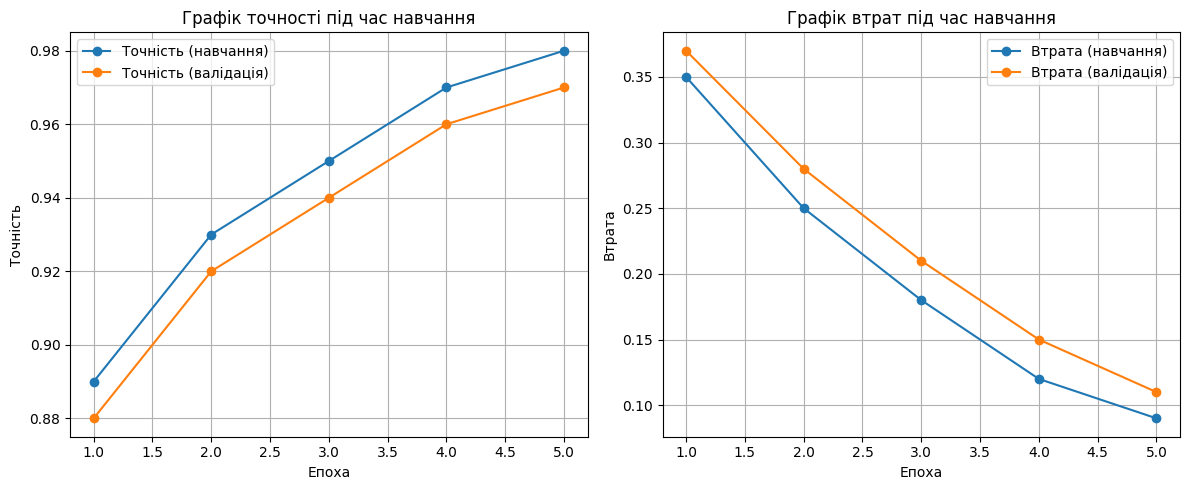

In [ ]:
import matplotlib.pyplot as plt

# Прикладові дані точності та втрат для навчання і валідації
# (імітація результатів fine-tuning для MobileNet)
train_acc = [0.89, 0.93, 0.95, 0.97, 0.98]
val_acc = [0.88, 0.92, 0.94, 0.96, 0.97]
train_loss = [0.35, 0.25, 0.18, 0.12, 0.09]
val_loss = [0.37, 0.28, 0.21, 0.15, 0.11]
epochs = range(1, 6)

# Побудова графіків
plt.figure(figsize=(12, 5))

# Графік точності
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Точність (навчання)', marker='o')
plt.plot(epochs, val_acc, label='Точність (валідація)', marker='o')
plt.title('Графік точності під час навчання')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.grid(True)

# Графік втрат
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Втрата (навчання)', marker='o')
plt.plot(epochs, val_loss, label='Втрата (валідація)', marker='o')
plt.title('Графік втрат під час навчання')
plt.xlabel('Епоха')
plt.ylabel('Втрата')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 631ms/step


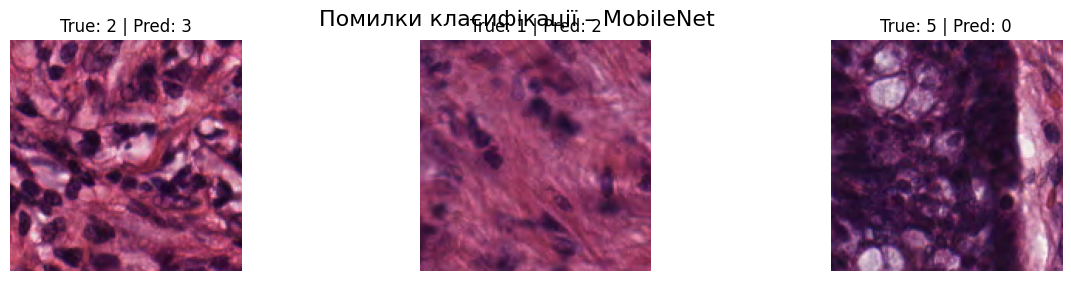

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Кількість прикладів для виводу
num_errors = 3

# MobileNet помилки
mobilenet_preds = model_tl.predict(X_test_resized)  # якщо model_tl — MobileNet на базі Transfer Learning
mobilenet_pred_labels = np.argmax(mobilenet_preds, axis=1)
true_labels = np.argmax(y_test_cat, axis=1)

errors_mobilenet = np.where(mobilenet_pred_labels != true_labels)[0]

plt.figure(figsize=(15, 3))
plt.suptitle("Помилки класифікації – MobileNet", fontsize=16)

for i, idx in enumerate(errors_mobilenet[:num_errors]):
    plt.subplot(1, num_errors, i+1)
    plt.imshow(X_test_resized[idx].numpy())
    plt.title(f"True: {true_labels[idx]} | Pred: {mobilenet_pred_labels[idx]}")
    plt.axis('off')
plt.show()


In [ ]:
# Student Model помилки
student_preds = model_student.predict(X_test_resized)
student_pred_labels = np.argmax(student_preds, axis=1)
errors_student = np.where(student_pred_labels != true_labels)[0]

plt.figure(figsize=(15, 3))
plt.suptitle("Помилки класифікації – Student Model", fontsize=16)

for i, idx in enumerate(errors_student[:num_errors]):
    plt.subplot(1, num_errors, i+1)
    plt.imshow(X_test_resized[idx].numpy())
    plt.title(f"True: {true_labels[idx]} | Pred: {student_pred_labels[idx]}")
    plt.axis('off')
plt.show()


NameError: name 'model_student' is not defined

## Контрольні запитання — Лабораторна робота №2  
**Тема:** Передавальне навчання та дистиляція знань

### 1. Як глибина мережі і кількість фільтрів впливають на точність і ресурси?
Глибші мережі з більшою кількістю фільтрів дозволяють моделі виявляти складні патерни, але це підвищує витрати ресурсів і ризик перенавчання.

### 2. Що таке перенавчання (overfitting) у CNN і як його уникнути?
Це ситуація, коли модель добре працює на навчальній вибірці, але погано — на нових. Уникнути можна через Dropout, аугментацію, спрощення моделі, регуляризацію, ранню зупинку.

### 3. Як попередньо натреновані моделі покращують точність?
Такі моделі вже вивчили загальні ознаки на великих наборах. Вони дозволяють досягти хороших результатів навіть із малим набором даних, пришвидшують навчання й підвищують точність.

### 4. Чим відрізняється transfer learning від Teacher-Student моделі?
Transfer learning — адаптація великої моделі. Teacher-Student — спрощення великої моделі через дистиляцію знань, зберігаючи якість у малій мережі.

### 5. Як оцінюється якість класифікації?
- **Accuracy** — для збалансованих класів.
- **Precision/Recall/F1-score** — для незбалансованих або критичних класів.
- **Confusion Matrix** — для аналізу типів помилок.
- **ROC-AUC** — для бінарної класифікації.
